## Capstone Project 1

### Data preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

data = pd.read_csv("ford_car_price_prediction.csv")
data.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
5,Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
6,Puma,2019,22500,Manual,2029,Petrol,145,50.4,1.0
7,Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
8,Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2.0
9,Focus,2018,10000,Manual,48141,Petrol,145,61.4,1.0


In [2]:
data.describe()

,year,price,mileage,tax,mpg,engineSize
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,2016.993836,12280.198630,21907.027397,108.205479,58.609726,1.361438
std,1.632212,4447.710936,15874.464065,62.334075,9.577440,0.436243
min,2013.000000,3691.000000,5.000000,0.000000,20.900000,1.000000
25%,2016.000000,9000.000000,10174.000000,30.000000,54.300000,1.000000
50%,2017.000000,11199.000000,17863.500000,145.000000,58.900000,1.200000
75%,2018.000000,14998.000000,29859.750000,145.000000,65.700000,1.500000
max,2020.000000,42489.000000,88927.000000,570.000000,88.300000,5.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fuelType      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   float64
 8   engineSize    1460 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.8+ KB


In [4]:
data.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [5]:
print("Dataset dimensions:", data.shape)

Dataset dimensions: (1460, 9)


In [6]:
target_label = 'price'
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns

Index(['model', 'year', 'price', 'transmission', 'mileage', 'fueltype', 'tax',
       'mpg', 'enginesize'],
      dtype='object')

In [7]:
categorical_cols = ['model', 'transmission', 'fueltype']
numerical_cols = ['year', 'mileage', 'tax', 'mpg', 'enginesize']
y = data[[target_label]]

### 2. Exploratory Data Analysis (EDA)

### 2.1 Dataset dimensions

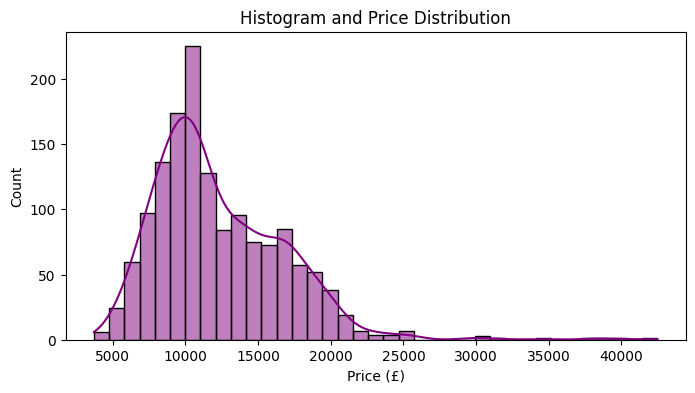

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(data['price'], kde=True, color='purple')
plt.title("Histogram and Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

In [ ]:
### 2.2 Univariate Analysis of Categorical Variables

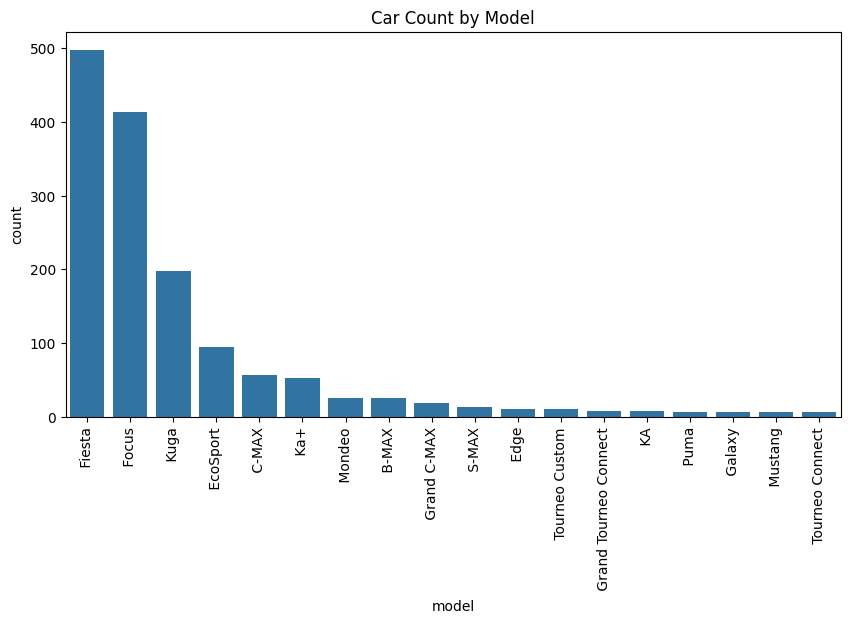

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(x='model', data=data, order=data['model'].value_counts().index)
plt.title("Car Count by Model")
plt.xticks(rotation=90)
plt.show()

### 2.3 Univariate Analysis of Numerical Variables

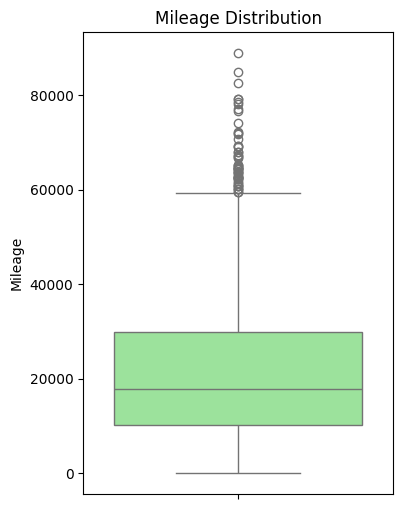

In [14]:
plt.figure(figsize=(4,6))
sns.boxplot(y='mileage', data=data, color='lightgreen')
plt.title("Mileage Distribution")
plt.ylabel("Mileage")
plt.show()

### 2.4 Categorical vs Target Relationship

/tmp/ipykernel_692/1250747153.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='fueltype', y='price', data=data, palette='pastel')


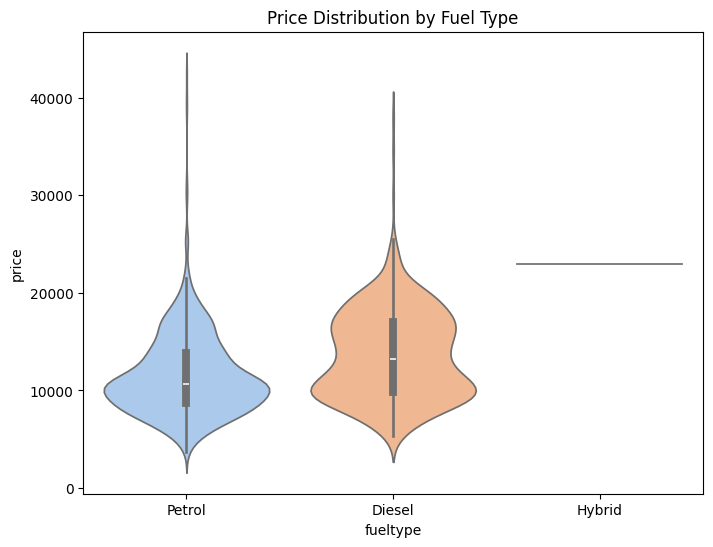

In [18]:
plt.figure(figsize=(8,6))
sns.violinplot(x='fueltype', y='price', data=data, palette='pastel')
plt.title("Price Distribution by Fuel Type")
plt.show()

### 2.5 Impacto de Categorias no Preço Médio

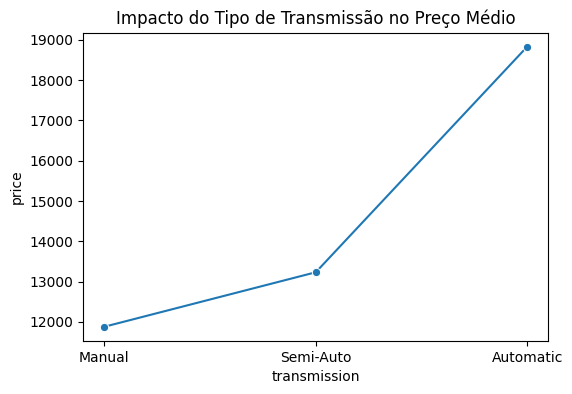

In [19]:
avg_price_trans = data.groupby('transmission')['price'].mean().reset_index().sort_values(by='price')
plt.figure(figsize=(6,4))
sns.lineplot(x='transmission', y='price', data=avg_price_trans, marker='o')
plt.title("Impact of Transmission Type on Average Price")
plt.show()

### 2.6 Relação Numérica vs Target (Scatterplot + Regressão)

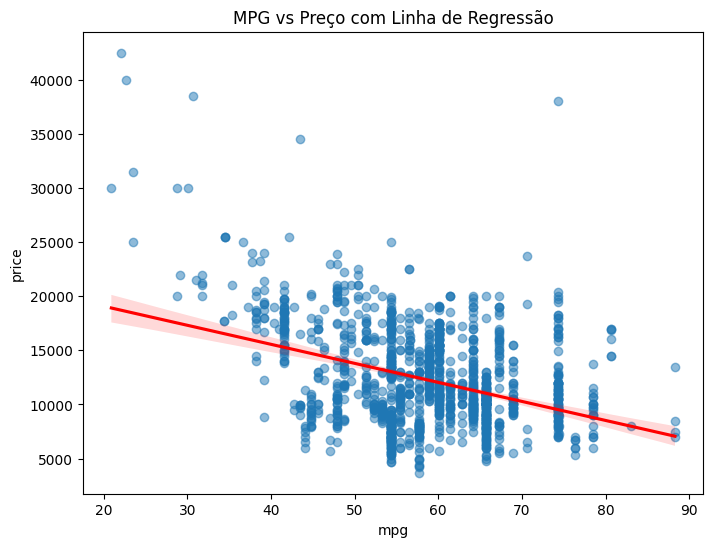

In [20]:
plt.figure(figsize=(8,6))
sns.regplot(x='mpg', y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
plt.title("MPG vs Preço com Linha de Regressão")
plt.show()

### 2.7 Jointplot (Relação Bivariada Detalhada)

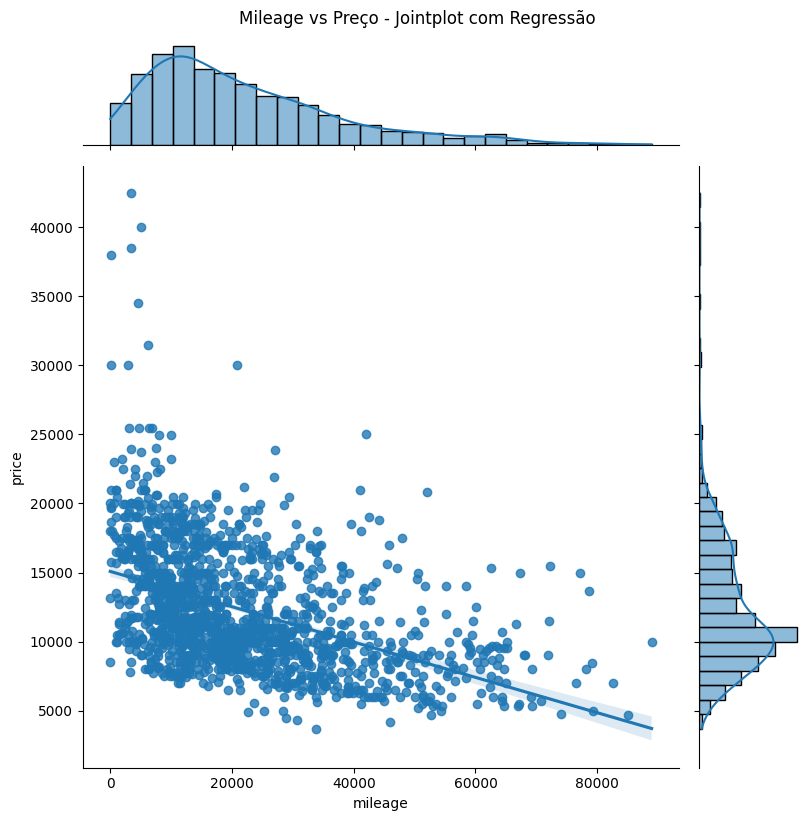

In [21]:
sns.jointplot(x='mileage', y='price', data=data, kind='reg', height=8)
plt.suptitle("Mileage vs Preço - Jointplot com Regressão", y=1.02)
plt.show()

### 2.8 Relação Categórica vs Categórica + Target (Heatmap)

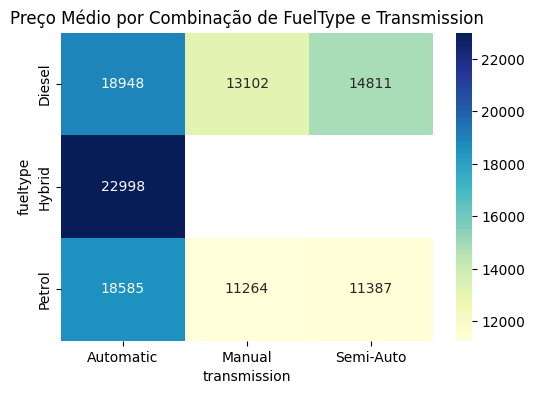

In [22]:
pivot_df = data.pivot_table(values='price', index='fueltype', columns='transmission', aggfunc='mean')
plt.figure(figsize=(6,4))
sns.heatmap(pivot_df, annot=True, cmap='YlGnBu', fmt=".0f")
plt.title("Preço Médio por Combinação de FuelType e Transmission")
plt.show()

### 2.9 Análise Multivariada (Pairplot)

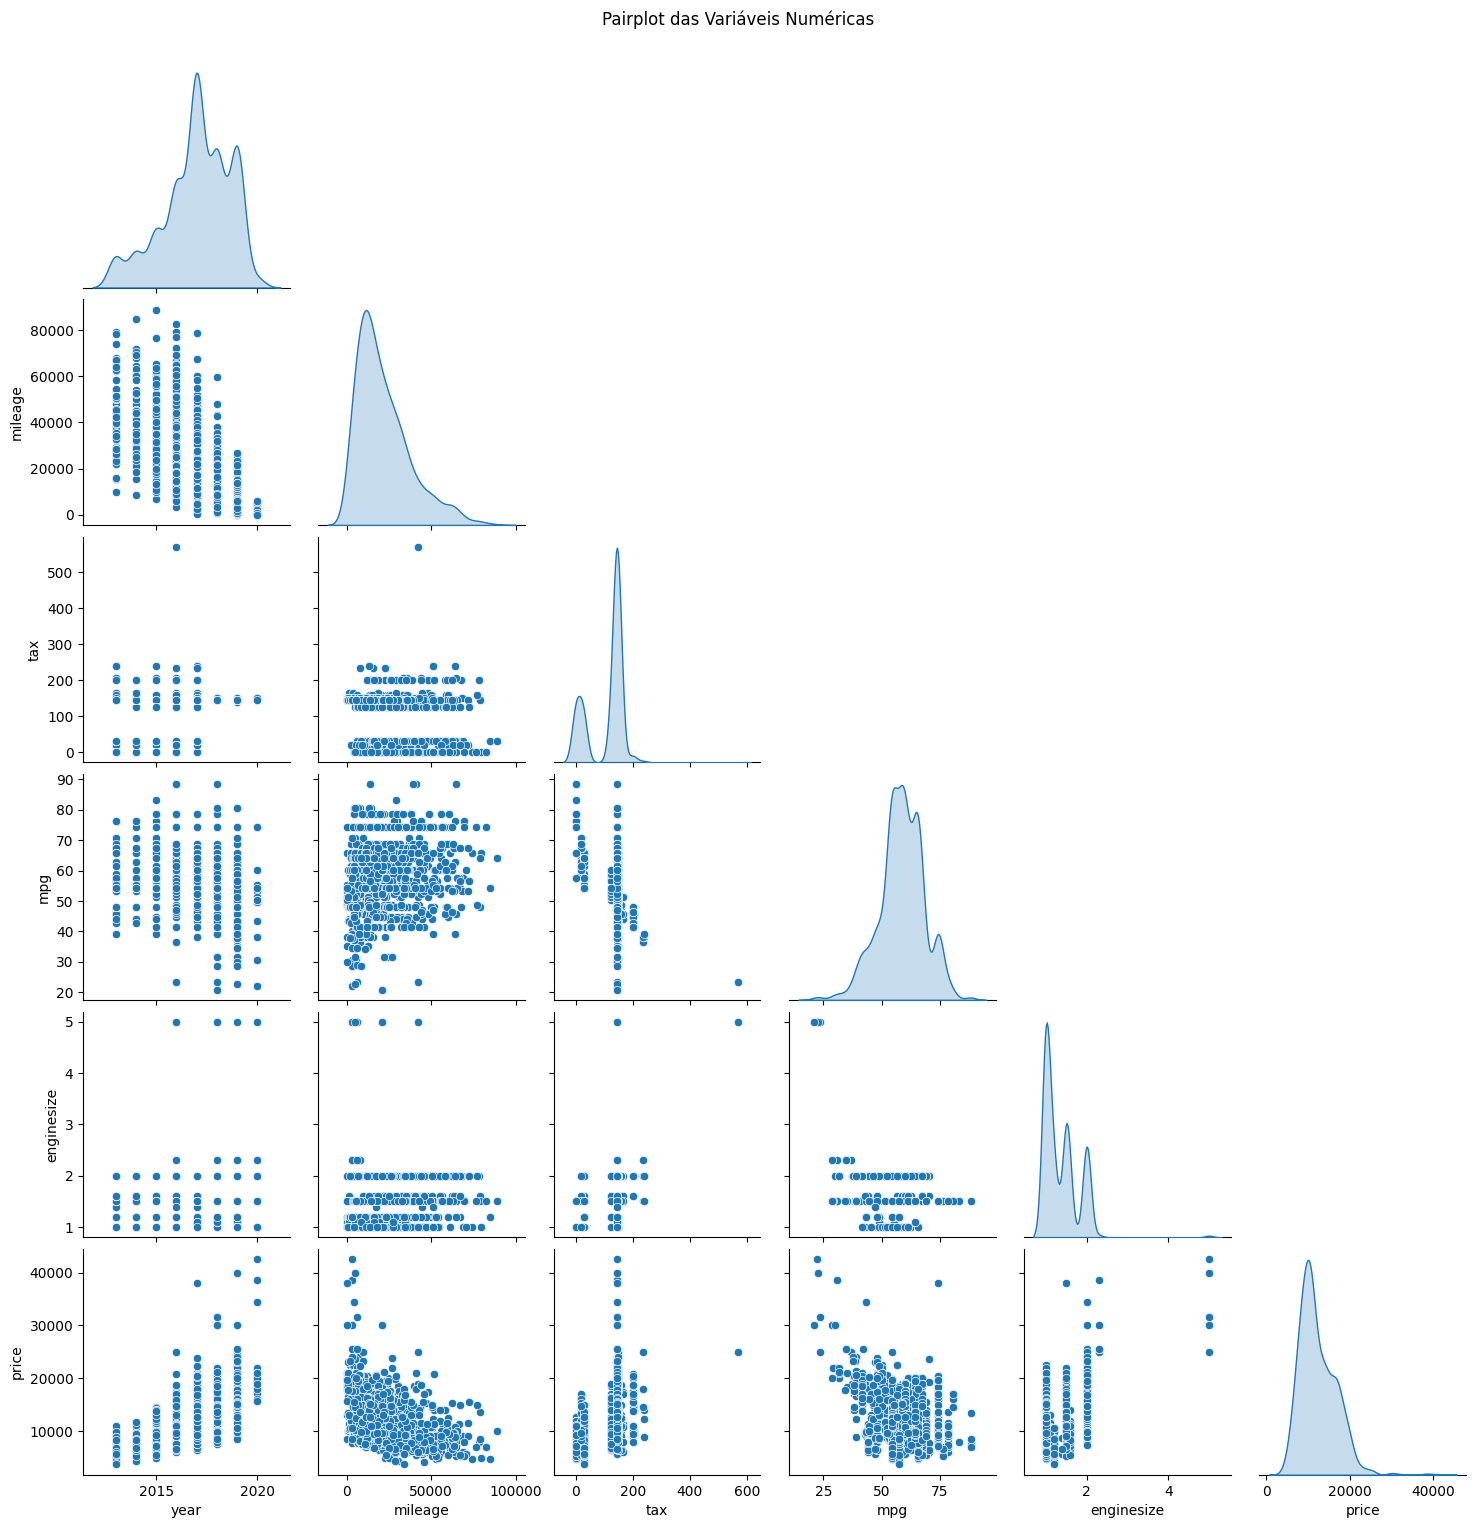

In [23]:
sns.pairplot(data, vars=['year','mileage','tax','mpg','enginesize','price'], diag_kind='kde', corner=True)
plt.suptitle("Pairplot das Variáveis Numéricas", y=1.02)
plt.show()